In [1]:
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path

In [2]:
# 加载数据集
json_path = 'dataset_qwen_pe_all.json'
with open(json_path, 'r') as f:
    dataset = json.load(f)

In [3]:
print(f"数据集总样本数: {len(dataset)}")

数据集总样本数: 24883


In [4]:
def overlay_mask(image_path, mask_path, alpha=0.5):
    """将 mask 叠加到图像上"""
    try:
        # 加载图像和 mask
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # 转换为灰度图
        
        # 调整 mask 尺寸以匹配图像
        if mask.size != image.size:
            mask = mask.resize(image.size, Image.LANCZOS)
        
        # 将图像和 mask 转换为 numpy 数组
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # 创建彩色 mask (红色)
        mask_colored = np.zeros_like(image_np)
        mask_colored[:, :, 0] = mask_np  # 红色通道
        
        # 叠加 mask
        mask_binary = (mask_np > 0).astype(float)
        mask_binary = np.expand_dims(mask_binary, axis=2)
        
        overlayed = image_np * (1 - alpha * mask_binary) + mask_colored * alpha * mask_binary
        overlayed = overlayed.astype(np.uint8)
        
        return Image.fromarray(overlayed)
    except Exception as e:
        print(f"处理图像时出错: {e}")
        return None

In [14]:
def visualize_sample(sample, index=None):
    """可视化一个样本"""
    print("=" * 80)
    if index is not None:
        print(f"样本索引: {index}")
    print(f"\nPrompt: {sample['prompt']}")
    print(f"\n图像路径:")
    print(f"  - edit_image (输入): {sample['edit_image']}")
    print(f"  - image (GT): {sample['image']}")
    print(f"  - ref_gt: {sample['ref_gt']}")
    print(f"  - back_mask: {sample['back_mask']}")
    print("=" * 80)
    
    # 检查文件是否存在
    base_path = Path('pico-banana-400k-subject_driven/openimages')
    gt_path = base_path / sample['image']  # ground truth
    mask_path = base_path / sample['back_mask']
    ref_gt_path = base_path / sample['ref_gt']
    
    # 获取 edit_image 列表（输入图像）
    edit_images = sample['edit_image']
    if not isinstance(edit_images, list):
        edit_images = [edit_images]
    
    # 计算需要显示的图像数量
    num_images = 3 + len(edit_images)  # edit_images+mask, gt+mask, ref_gt, mask
    
    # 创建子图
    fig, axes = plt.subplots(2, max(2, (num_images + 1) // 2), figsize=(20, 10))
    axes = axes.flatten()
    
    idx = 0
    
    # 显示输入图像 (edit_image) + mask
    for i, edit_img in enumerate(edit_images):
        edit_path = base_path / edit_img
        if edit_path.exists() and mask_path.exists():
            overlayed_edit = overlay_mask(str(edit_path), str(mask_path))
            if overlayed_edit:
                axes[idx].imshow(overlayed_edit)
                title = f'Input Image {i+1} + Mask' if len(edit_images) > 1 else 'Input Image + Mask'
                axes[idx].set_title(title, fontsize=12, fontweight='bold')
                axes[idx].axis('off')
                idx += 1
        else:
            print(f"警告: 文件不存在 - {edit_path} 或 {mask_path}")
    
    # 显示 Ground Truth (image) + mask
    if gt_path.exists() and mask_path.exists():
        overlayed_gt = overlay_mask(str(gt_path), str(mask_path))
        if overlayed_gt:
            axes[idx].imshow(overlayed_gt)
            axes[idx].set_title('Ground Truth + Mask', fontsize=12, fontweight='bold')
            axes[idx].axis('off')
            idx += 1
    else:
        print(f"警告: 文件不存在 - {gt_path} 或 {mask_path}")
    
    # 显示参考 ground truth
    if ref_gt_path.exists():
        ref_gt = Image.open(str(ref_gt_path))
        axes[idx].imshow(ref_gt)
        axes[idx].set_title('Reference Ground Truth', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        idx += 1
    else:
        print(f"警告: 文件不存在 - {ref_gt_path}")
    
    # 显示纯 mask
    if mask_path.exists():
        mask = Image.open(str(mask_path))
        axes[idx].imshow(mask, cmap='gray')
        axes[idx].set_title('Mask', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        idx += 1
    
    # 隐藏多余的子图
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


样本索引: 12770

Prompt: Picture 1 is the image to modify. Remove the yellow and red toy from the foreground, seamlessly replacing the area it occupied with the textured orange mat, matching its color, lighting, and soft focus to integrate naturally into the existing surface.

图像路径:
  - image: edited/sft/192999.png
  - edit_image: ['edit_aligned_all/edit_aligned_31029.png']
  - ref_gt: ref_gt_generated_all/ref_gt_31029.png
  - back_mask: ref_gt_generated_all/mask_combined_31029.png


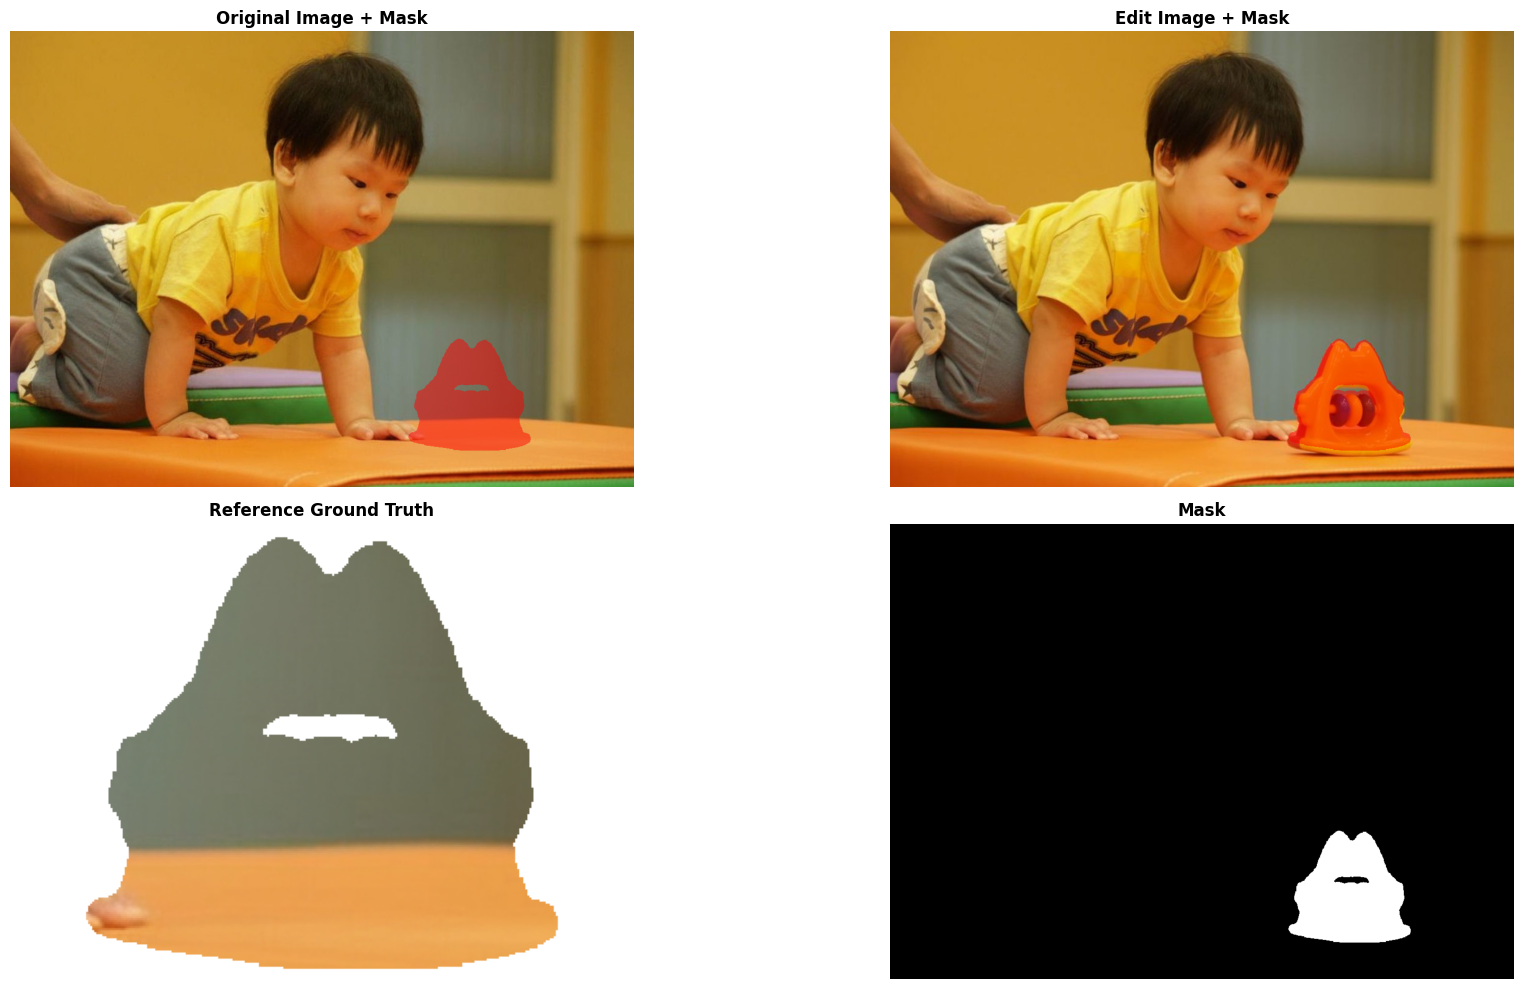

In [8]:
# 随机选择一个样本并可视化
random_index = random.randint(0, len(dataset) - 1)
random_sample = dataset[random_index]
visualize_sample(random_sample, random_index)

样本索引: 20984

Prompt: Picture 1 is the image to modify. Change the blue t-shirt worn by the person in the background to a dark olive green, ensuring the fabric texture and the dim, ambient lighting are realistically preserved for a seamless integration into the scene.

图像路径:
  - edit_image (输入): ['edit_aligned_all/edit_aligned_45002.png']
  - image (GT): edited/sft/kevvs4_retry1.png
  - ref_gt: ref_gt_generated_all/ref_gt_45002.png
  - back_mask: ref_gt_generated_all/mask_combined_45002.png


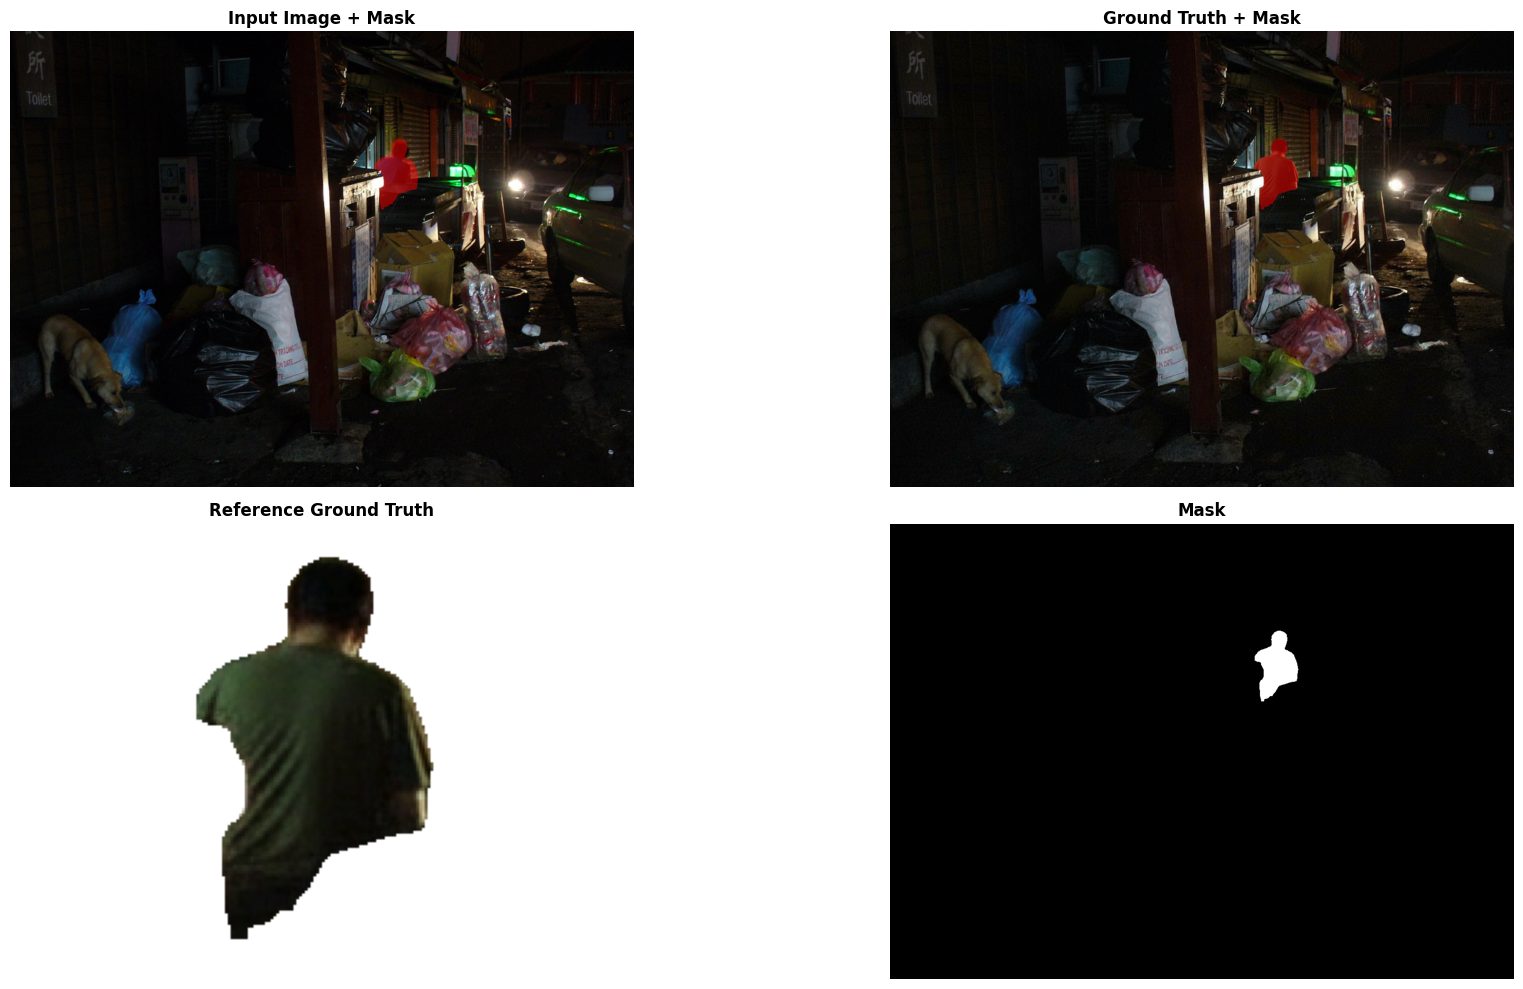

In [50]:
# 连续查看多个随机样本（运行此单元格查看下一个随机样本）
def view_random_samples(n=1):
    """查看 n 个随机样本"""
    for _ in range(n):
        random_index = random.randint(0, len(dataset) - 1)
        random_sample = dataset[random_index]
        visualize_sample(random_sample, random_index)

# 查看一个随机样本
view_random_samples(1)

样本索引: 1

Prompt: Picture 1 is the image to modify. Remove the adult white and grey seagull from the metal grate, meticulously reconstructing the underlying weathered metal mesh and the rusted boat structure with matching textures, color, and lighting to seamlessly integrate with the surrounding environment.

图像路径:
  - edit_image (输入): ['edit_aligned_all/edit_aligned_10018.png']
  - image (GT): edited/sft/62991.png
  - ref_gt: ref_gt_generated_all/ref_gt_10018.png
  - back_mask: ref_gt_generated_all/mask_combined_10018.png


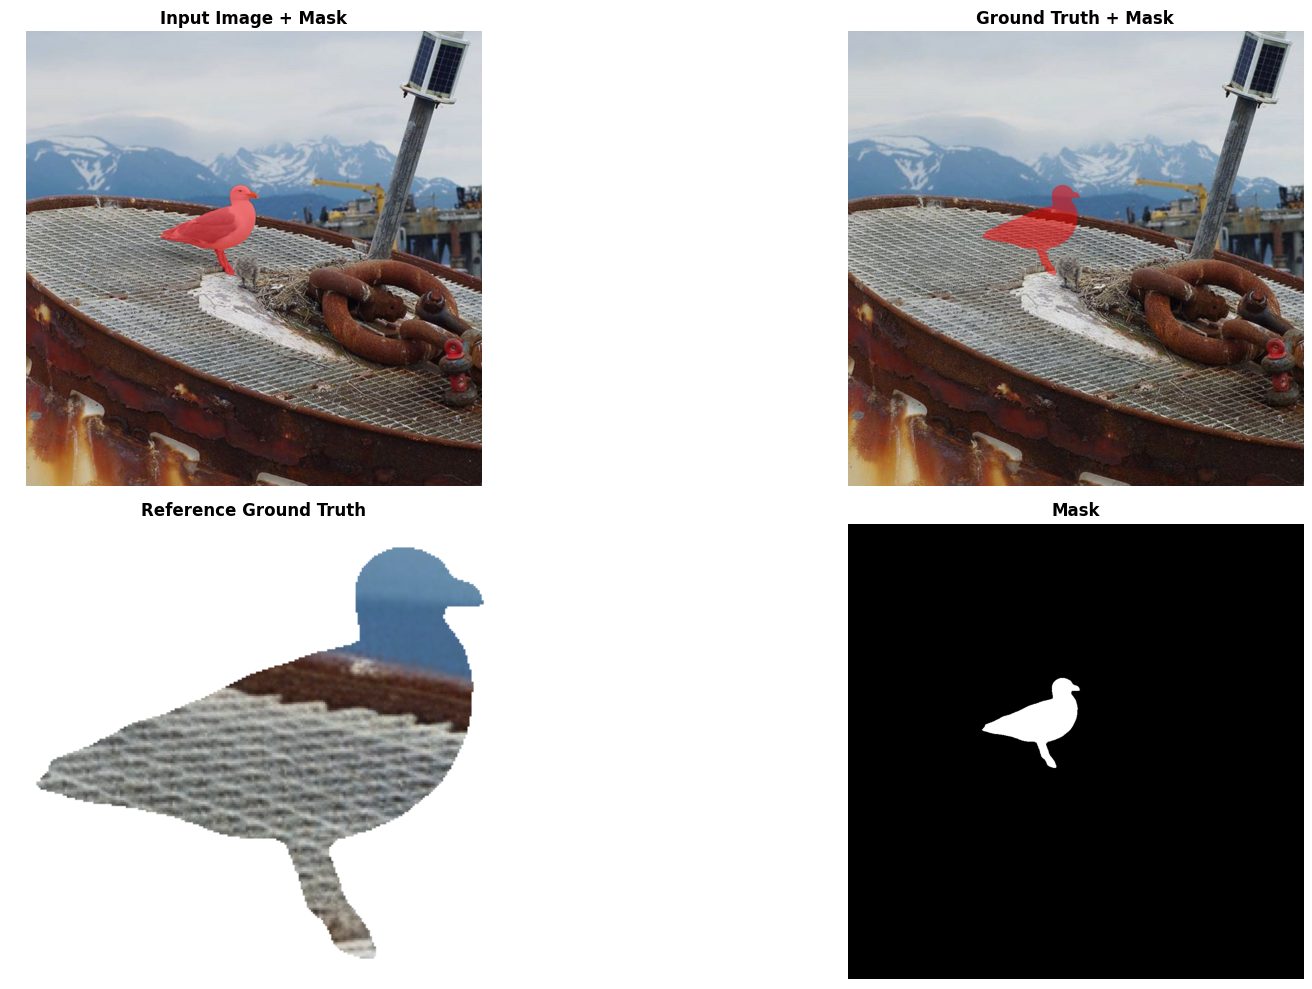

In [52]:
# 查看指定索引的样本
def view_sample_by_index(index):
    """查看指定索引的样本"""
    if 0 <= index < len(dataset):
        visualize_sample(dataset[index], index)
    else:
        print(f"错误: 索引 {index} 超出范围 [0, {len(dataset)-1}]")

# 示例：查看索引为 0 的样本
view_sample_by_index(1)